In [1]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb


In [6]:
# Some paths
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
pklPath = 'pkl/'


# The 6 birds from Julie data set
birds = ['BlaBro09xxF', 'GreBlu9508M', 'WhiBlu5396M', 'LblBlu2028M', 'WhiWhi4522M', 'YelBlu6903F']

In [7]:
# Load the data base
outPath = rootPath+'JulieDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()


In [8]:
dfDataBase

,bird,site,unit,stim,call,trial,R,z,PC
0,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,0,-1.0,-0.549909,"[-275.2118717970431, -10.307135165349319, -5.2..."
1,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,1,0.0,0.000000,"[-286.57869828006017, 4.927337354376003, 1.460..."
2,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,2,1.0,0.549909,"[-252.6817287180196, -37.24449582663322, 13.43..."
3,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,3,-2.0,-1.099818,"[-263.8467752091148, -22.292874807921606, -9.4..."
4,BlaBro09xxF,Site3_L2500R2300,e18_s1_ss2,WhiWhi1415_FAF_Ne_3-8-9.wav,Ne,4,0.0,0.000000,"[-286.57869828006017, 4.927337354376003, 1.460..."
...,...,...,...,...,...,...,...,...,...
737125,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,6,2.0,0.326913,"[-113.5444937243995, 116.46795979458244, 68.96..."
737126,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,7,4.0,0.653826,"[-114.11070843314403, 53.31764065476622, 11.66..."
737127,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,8,1.0,0.163457,"[-172.31950013296793, 35.51034079569622, 9.850..."
737128,YelBlu6903F,Site2_L1000R900,e20_s0_ss1,WhiWhi1415_FAF_DC_6-2-4.wav,DC,9,1.0,0.163457,"[-151.79975946977157, 158.46952818869502, 89.3..."


In [9]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']

In [10]:
# Number of Units
unitNames = np.unique(dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'])
nunits = unitNames.shape[0]

# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

# Stims per Units
nstimsUnit = dict()
unitNamesFull = []
for unit in unitNames:
    nstimsUnit[unit] = len(np.unique(dfDataBaseNW['stim'][dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]))
    # Select only Units with 110 stimuli (for now)
    if (nstimsUnit[unit] >= 110):
        unitNamesFull.append(unit)
    
nunitsFull = len(unitNamesFull)

print(nunitsFull)



609


In [12]:
ncalls

9

In [15]:
def naiveBayes(unitChoice, plotFlg = False, usingAllCombos = False, code='z'):
    # naiveBayes runs a guassian classifier for call types using the responses in the units in the list unitChoice
    # For now it uses the zscore in the dfDataBaseNW
    
    # Number of units
    numUnits = len(unitChoice)
    
    # Number of PCs (for PC code)
    nPCs = dfDataBaseNW['PC'][0].shape[0]
    
    # Find the unique stims played for the chosen unit
    unitIndexDict = dict()
    unitIndexLen = []
    stimList = []
    for unit in unitChoice:   
        unitIndex = dfDataBaseNW.index[dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]
        unitIndexDict[unit] = unitIndex
        unitIndexLen.append(len(unitIndex))
        stimList.extend(list(dfDataBaseNW['stim'][unitIndex].array))
    
    stimNames = np.unique(stimList)
    
    # Generate ensemble responses  for the units in unitChoice

    # Training Trials
    rowListList = []
    totTrials = 0

    # Testing Trials
    rowListListTest = []
    totTestTrials = 0

    for stim in stimNames:
        goodStim = 2    # This means that we have at least two trials for each stim for all units
        
        # Check to see if we have enough trials for all units for this stim
        for unit in unitChoice:
            unitIndex = unitIndexDict[unit]
            unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
            if len(unitIndexStim) == 0:
                goodStim = 0
                print('Stim ', stim, 'has no response for unit', unit, '. Skipping')
                break
            elif len(unitIndexStim) == 1:
                goodStim = 1
            
        # If so continue
        if goodStim > 0 :
            rowList2Cat = []
            rowList2CatLen = []
            for unit in unitChoice:
                unitIndex = unitIndexDict[unit]
                unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
                rowList2Cat.append(unitIndexStim)
                rowList2CatLen.append(len(unitIndexStim))
            
            if goodStim > 1 :  # Use one of the responses for the test set
                listTest = []
                for iunit, unit in enumerate(unitChoice):
                    rowchosen = np.random.choice(rowList2Cat[iunit], 1, replace=False)
                    listTest.append(rowchosen[0])
                    rowList2Cat[iunit].remove(rowchosen)
                    rowList2CatLen[iunit] = len(rowList2Cat[iunit])
                rowListListTest.append(listTest)
                totTestTrials +=1
            
            if usingAllCombos:
                numSamp = np.prod(rowList2CatLen)
                totTrials += numSamp
            
                list_of_lists = []

                indUnit = np.zeros((numUnits,), dtype=int)
                indUnit[0] = -1
            
                for i in range(numSamp):
                    for iunit, unit in enumerate(unitChoice):
                        indUnit[iunit] += 1
                        if (indUnit[iunit] >= len(rowList2Cat[iunit]) ):
                            indUnit[iunit] = 0
                        else: 
                            break
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        trialList.append(rowList2Cat[iunit][indUnit[iunit]])
                
                    list_of_lists.append(trialList)
            else:
                numSamp = np.max(rowList2CatLen)
                totTrials += numSamp
                    
                list_of_lists = []
                for i in range(numSamp):
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        if i < len(rowList2Cat[iunit]):
                            trialList.append(rowList2Cat[iunit][i])
                        else:
                            trialList.append(np.random.choice(rowList2Cat[iunit], 1, replace=False)[0])
                    list_of_lists.append(trialList)
        
            rowListList.extend(list_of_lists)

    print('Total number of trials:', totTrials)
    print('Total number of test trials:', totTestTrials)
    
    # Make X (neural code), Y (call type)
    if code == 'z':
        Xfit = np.zeros((totTrials, numUnits*1))
        Xtest = np.zeros((totTestTrials, numUnits*1))
    elif code == 'PC':
        Xfit = np.zeros((totTrials, numUnits*(1+nPCs)))
        Xtest = np.zeros((totTestTrials, numUnits*(1+nPCs)))
        
    Yfit = []
    for irow,rowList in enumerate(rowListList):
        if code == 'z':
            Xfit[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xfit[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
            
        Yfit.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    Yfit = np.array(Yfit)

    
    Ytest = []
    for irow,rowList in enumerate(rowListListTest):
        if code == 'z':
            Xtest[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xtest[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
        Ytest.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    
    Ytest = np.array(Ytest)
    
    
    # Fit and test the classifier clf
    nClasses = len(np.unique(Yfit))

    clf = GaussianNB(priors=np.ones((nClasses,))/nClasses)
    clf.fit(Xfit,Yfit)

    probTest = clf.predict_proba(Xtest)

    # Make a confusion matrix
    confMat = np.zeros((nClasses,nClasses))
    testsPerClass = np.zeros((nClasses,))

    for i,y in enumerate(Ytest):
        classID = np.argwhere(clf.classes_ == y)
        testsPerClass[classID] += 1    
        confMat[classID,:] += probTest[i]
    
    # The confusion matrix is not normalized so that we can average it correctly later on.. 
    #for i in range(nClasses):
    #    confMat[i,:] /= testsPerClass[i]
    
    # Print percent correct classification by taking average of diagonal of confusion matrix.
    sumCorrect = np.trace(confMat)
    sumTest = np.sum(testsPerClass)
    pcc = 100.0*(sumCorrect/sumTest)
    print('PCC %.0f %%' % (pcc))
    
    if plotFlg:
        # Normalize confMat for display
        confMatNorm = np.zeros((nClasses,nClasses))
        for i in range(nClasses):
            if testsPerClass[i] > 0 :
                confMatNorm[i,:] = confMat[i,:]/testsPerClass[i]
                
        # Display comfusion matrix
        cmap='viridis'
        fig, ax = plt.subplots()
        im_ = ax.imshow(confMat*100.0, interpolation='nearest', cmap=cmap)

        fig.colorbar(im_, ax=ax)
        ax.set(xticks=np.arange(nClasses),
               yticks=np.arange(nClasses),
               xticklabels=clf.classes_,
               yticklabels=clf.classes_,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='PPC %.0f %%' % (pcc))
    
    return pcc, confMat, testsPerClass



In [21]:
# Loop through all neurons and PC 
numUnits = 1
code = 'PC'


# Choose random units
# unitChoice = np.random.choice(unitNamesFull, numUnits, replace=False)
# comb(nunitsFull, 3)
pcc = np.zeros((nunitsFull,))
confMatTot = np.zeros((ncalls, ncalls))
confMatCount = np.zeros((ncalls,))

for i,unit in enumerate(unitNamesFull):
    unitChoice = [unit]
    pcc[i], confMat, testsPerClass = naiveBayes(unitChoice, plotFlg = False, code = code)
    if (confMat.shape == (ncalls,ncalls) ) :
        confMatTot = np.add(confMatTot, confMat)
        confMatCount += testsPerClass

for i in range(ncalls):
    if confMatCount[i] > 0:
        confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]

# this is to save the results of pcc for chosing only single neurons with pcc > 13
if ((numUnits == 1) & (code == 'PC')):
    # save the PC and Confusion matrices data base
    outPath = rootPath+pklPath+'JulieDataBase1UnitPCNW.pkl'
    fileOut = open(outPath,"wb")
    pk.dump(unitNamesFull, fileOut)
    pk.dump(confMatTot, fileOut)
    pk.dump(pcc, fileOut)
    fileOut.close()


Total number of trials: 1089
Total number of test trials: 121
PCC 14 %
Total number of trials: 1089
Total number of test trials: 121
PCC 15 %
Total number of trials: 1089
Total number of test trials: 121
PCC 11 %
Total number of trials: 1089
Total number of test trials: 121
PCC 11 %
Total number of trials: 1089
Total number of test trials: 121
PCC 11 %
Total number of trials: 1089
Total number of test trials: 121
PCC 12 %
Total number of trials: 1089
Total number of test trials: 121
PCC 11 %
Total number of trials: 1089
Total number of test trials: 121
PCC 14 %
Total number of trials: 1089
Total number of test trials: 121
PCC 12 %
Total number of trials: 1089
Total number of test trials: 121
PCC 11 %
Total number of trials: 1089
Total number of test trials: 121
PCC 11 %
Total number of trials: 990
Total number of test trials: 110
PCC 12 %
Total number of trials: 990
Total number of test trials: 110
PCC 13 %
Total number of trials: 990
Total number of test trials: 110
PCC 15 %
Total num

Total number of trials: 1080
Total number of test trials: 120
PCC 14 %
Total number of trials: 1080
Total number of test trials: 120
PCC 11 %
Total number of trials: 1080
Total number of test trials: 120
PCC 11 %
Total number of trials: 1080
Total number of test trials: 120
PCC 11 %
Total number of trials: 1080
Total number of test trials: 120
PCC 12 %
Total number of trials: 1080
Total number of test trials: 120
PCC 8 %
Total number of trials: 1080
Total number of test trials: 120
PCC 12 %
Total number of trials: 1080
Total number of test trials: 120
PCC 13 %
Total number of trials: 1080
Total number of test trials: 120
PCC 12 %
Total number of trials: 1080
Total number of test trials: 120
PCC 13 %
Total number of trials: 1080
Total number of test trials: 120
PCC 13 %
Total number of trials: 1080
Total number of test trials: 120
PCC 15 %
Total number of trials: 1080
Total number of test trials: 120
PCC 12 %
Total number of trials: 1094
Total number of test trials: 119
PCC 11 %
Total n

Total number of trials: 1106
Total number of test trials: 121
PCC 12 %
Total number of trials: 1106
Total number of test trials: 121
PCC 11 %
Total number of trials: 1106
Total number of test trials: 121
PCC 13 %
Total number of trials: 1106
Total number of test trials: 121
PCC 11 %
Total number of trials: 1106
Total number of test trials: 121
PCC 11 %
Total number of trials: 1106
Total number of test trials: 121
PCC 11 %
Total number of trials: 1135
Total number of test trials: 120
PCC 11 %
Total number of trials: 1135
Total number of test trials: 120
PCC 11 %
Total number of trials: 1135
Total number of test trials: 120
PCC 11 %
Total number of trials: 1135
Total number of test trials: 120
PCC 11 %
Total number of trials: 1135
Total number of test trials: 120
PCC 11 %
Total number of trials: 1135
Total number of test trials: 120
PCC 11 %
Total number of trials: 1135
Total number of test trials: 120
PCC 12 %
Total number of trials: 1135
Total number of test trials: 120
PCC 11 %
Total 

Total number of trials: 1106
Total number of test trials: 120
PCC 11 %
Total number of trials: 1106
Total number of test trials: 120
PCC 13 %
Total number of trials: 1106
Total number of test trials: 120
PCC 14 %
Total number of trials: 1106
Total number of test trials: 120
PCC 15 %
Total number of trials: 1106
Total number of test trials: 120
PCC 13 %
Total number of trials: 1106
Total number of test trials: 120
PCC 12 %
Total number of trials: 1052
Total number of test trials: 121
PCC 11 %
Total number of trials: 1052
Total number of test trials: 121
PCC 11 %
Total number of trials: 1052
Total number of test trials: 121
PCC 12 %
Total number of trials: 1052
Total number of test trials: 121
PCC 16 %
Total number of trials: 1052
Total number of test trials: 121
PCC 15 %
Total number of trials: 1052
Total number of test trials: 121
PCC 13 %
Total number of trials: 1052
Total number of test trials: 121
PCC 12 %
Total number of trials: 1052
Total number of test trials: 121
PCC 6 %
Total n

Total number of trials: 1080
Total number of test trials: 120
PCC 14 %
Total number of trials: 1080
Total number of test trials: 120
PCC 12 %
Total number of trials: 1080
Total number of test trials: 120
PCC 11 %
Total number of trials: 1080
Total number of test trials: 120
PCC 12 %
Total number of trials: 1080
Total number of test trials: 120
PCC 15 %
Total number of trials: 1080
Total number of test trials: 120
PCC 11 %
Total number of trials: 1080
Total number of test trials: 120
PCC 11 %
Total number of trials: 1080
Total number of test trials: 120
PCC 16 %
Total number of trials: 1080
Total number of test trials: 120
PCC 17 %
Total number of trials: 1080
Total number of test trials: 120
PCC 21 %
Total number of trials: 1080
Total number of test trials: 120
PCC 15 %
Total number of trials: 1080
Total number of test trials: 120
PCC 13 %
Total number of trials: 1080
Total number of test trials: 120
PCC 15 %
Total number of trials: 1080
Total number of test trials: 120
PCC 11 %
Total 

Total number of trials: 1108
Total number of test trials: 123
PCC 11 %
Total number of trials: 1108
Total number of test trials: 123
PCC 12 %
Total number of trials: 1108
Total number of test trials: 123
PCC 12 %
Total number of trials: 1108
Total number of test trials: 123
PCC 12 %
Total number of trials: 1108
Total number of test trials: 123
PCC 14 %
Total number of trials: 1108
Total number of test trials: 123
PCC 11 %
Total number of trials: 1108
Total number of test trials: 123
PCC 11 %
Total number of trials: 1108
Total number of test trials: 123
PCC 12 %
Total number of trials: 1108
Total number of test trials: 123
PCC 17 %
Total number of trials: 1108
Total number of test trials: 123
PCC 21 %
Total number of trials: 1108
Total number of test trials: 123
PCC 12 %
Total number of trials: 1108
Total number of test trials: 123
PCC 12 %
Total number of trials: 1108
Total number of test trials: 123
PCC 13 %
Total number of trials: 1108
Total number of test trials: 123
PCC 13 %
Total 

In [24]:
# this is to save the results of pcc for chosing only single neurons with pcc > 13
if ((numUnits == 1) & (code == 'PC')):
    # save the PC and Confusion matrices data base
    outPath = rootPath+pklPath+'JulieDataBase1UnitPCNW.pkl'
    fileOut = open(outPath,"wb")
    pk.dump(unitNamesFull, fileOut)
    pk.dump(confMatTot, fileOut)
    pk.dump(pcc, fileOut)
    fileOut.close()

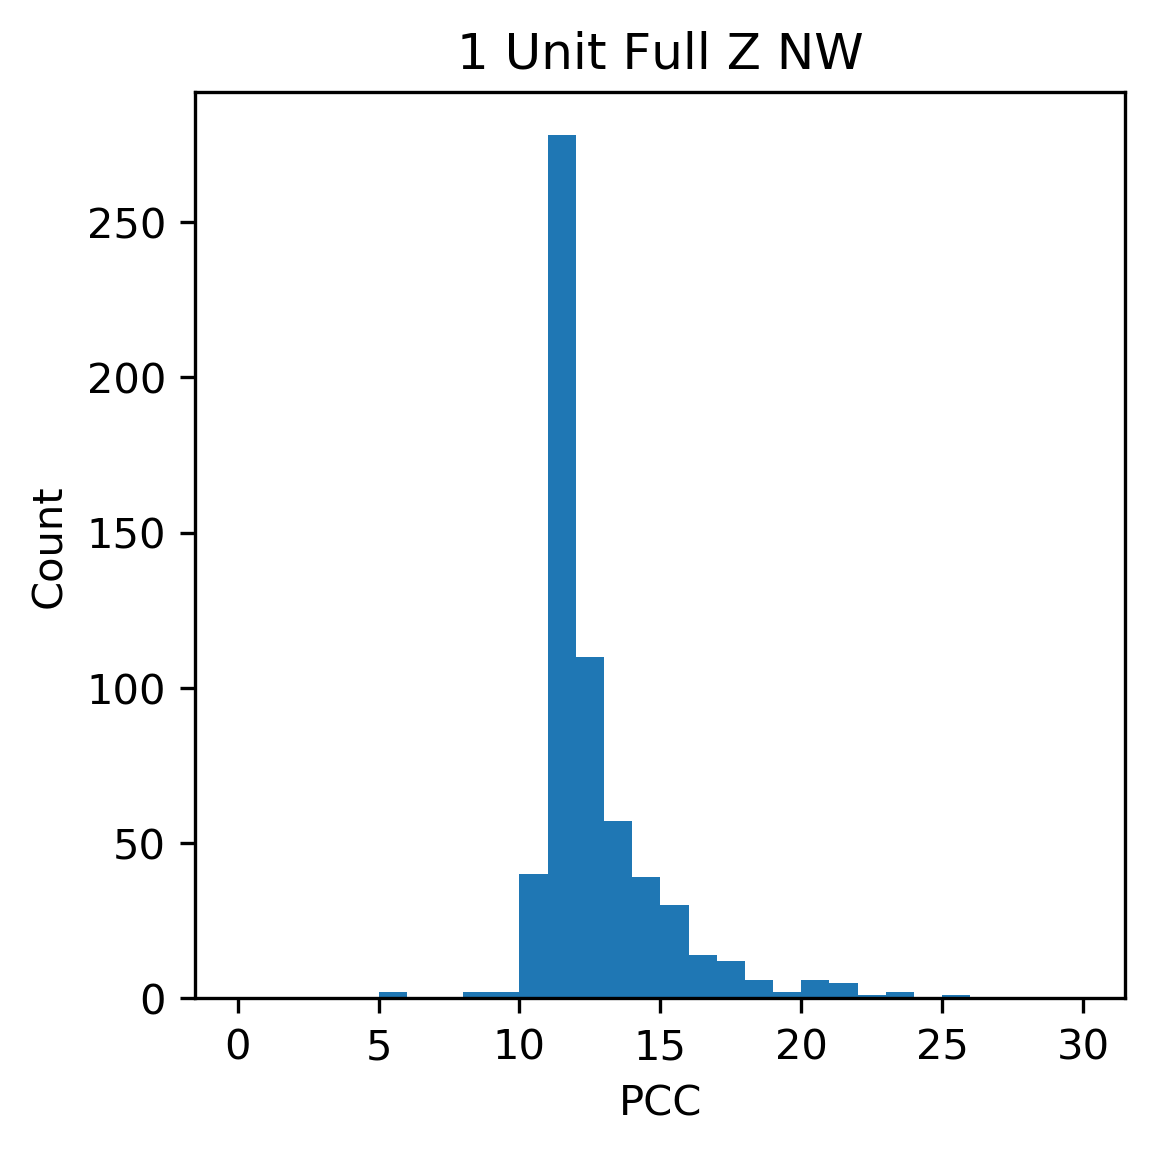

In [22]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

ax.hist(pcc, bins = 30, range = (0,30))
ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('1 Unit Full Z NW')

plt.savefig('/Users/frederictheunissen/Desktop/pcchist1UnitFULLZJulieNW.eps')

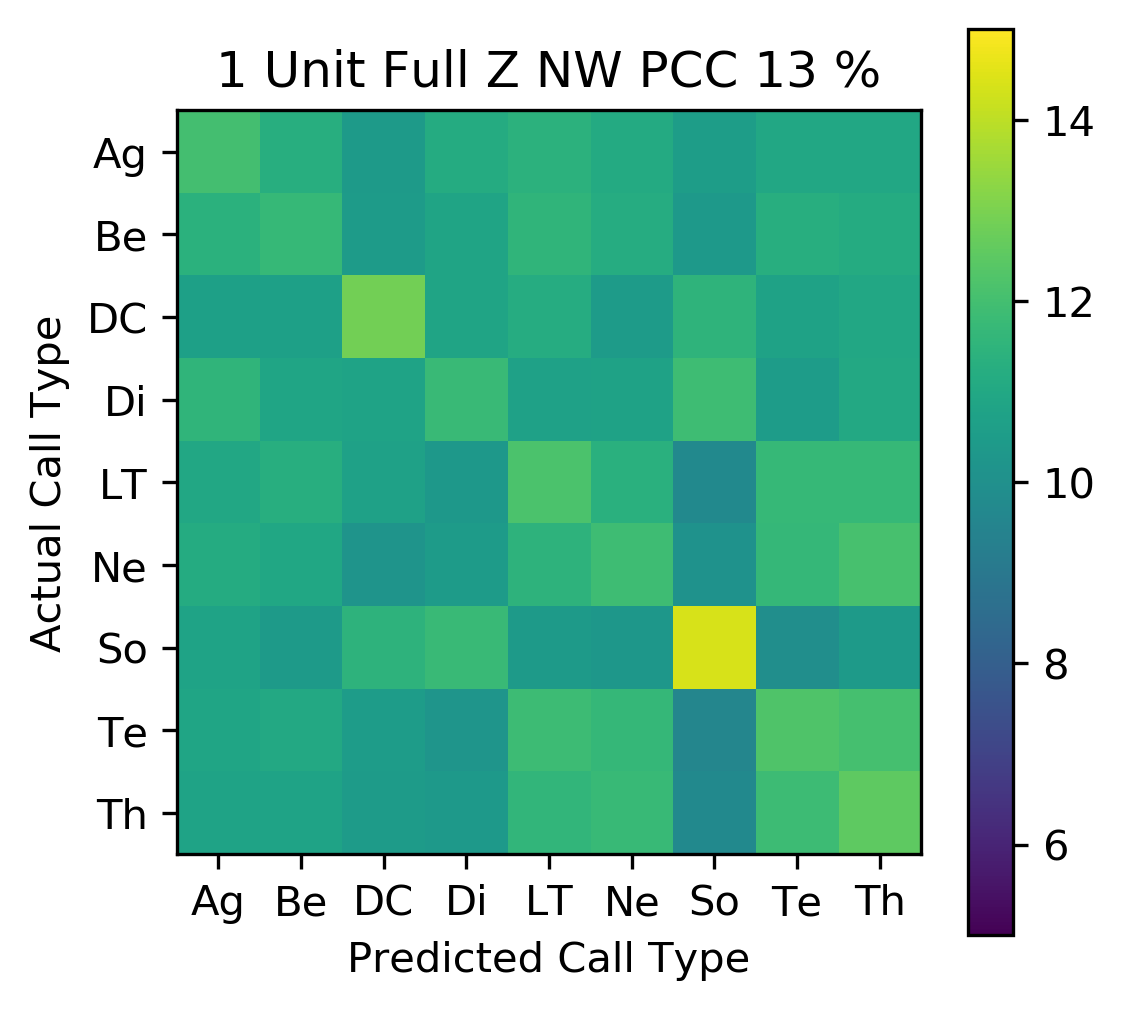

In [23]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()
im_ = ax.imshow(confMatTot*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 15)

fig.colorbar(im_, ax=ax)
ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='1 Unit Full Z NW PCC %.0f %%' % (np.mean(pcc)))

plt.savefig('/Users/frederictheunissen/Desktop/confMat1UnitFullZNW.eps')


In [20]:
callNames

array(['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'So', 'Te', 'Th'], dtype=object)